토크나이저 설정: KLUE/BERT

하드웨어 환경 확인
PyTorch 버전: 2.8.0+cu126
CUDA 사용 가능: False
CPU 전용 모드
사용 디바이스: cpu

모델 학습
모델 학습 모드
시퀀스 길이: 256
배치 크기: 3
모델 크기: 256

파일에서 1개의 문장 로드
KLUE/BERT 토크나이저 초기화 중...
토크나이징 진행: 1/1
토크나이저 정보
토크나이저 타입: KLUE/BERT WordPiece
어휘 크기: 54
토큰 예시: ['##고', '##곤', '##는', '##는데', '##다', '##를', '##만', '##배', '##세', '##송']
특수 토큰: ['<pad>', '<sos>', '<eos>', '<unk>']

위치 인코딩 정보
임베딩 차원: 256
최대 길이: 256
PE 값 범위: [-1.000, 1.000]
sin/cos 함수로 생성

모델 구조
모델 타입: GPT (Decoder-Only Transformer)
어휘 크기: 54
임베딩 차원: 256
어텐션 헤드: 16
디코더 층: 12
FFN 차원: 256
최대 시퀀스 길이: 256
드롭아웃: 0.1
총 파라미터: 4,777,526

배치 생성 중... (최대 시퀀스 길이: 256)
처리된 텍스트: 1/1, 생성된 시퀀스: 0
총 1개의 시퀀스가 생성...
총 1개의 배치 생성...
총 배치 수: 1
모델 학습 시작
학습 배치 수: 1
초기 학습률: 0.0003

Model Forward Pass Analysis
Input shape: torch.Size([1, 255])
Input token IDs (first sample): tensor([ 1, 34, 11, 41, 40, 20, 45, 16, 14, 48, 33, 26, 14, 49, 11, 37, 24, 19,
        13, 30, 38, 23, 53, 16, 14, 48, 35, 10, 51, 12, 29, 33, 50, 39, 36, 27,
        42,  9, 52, 18, 1

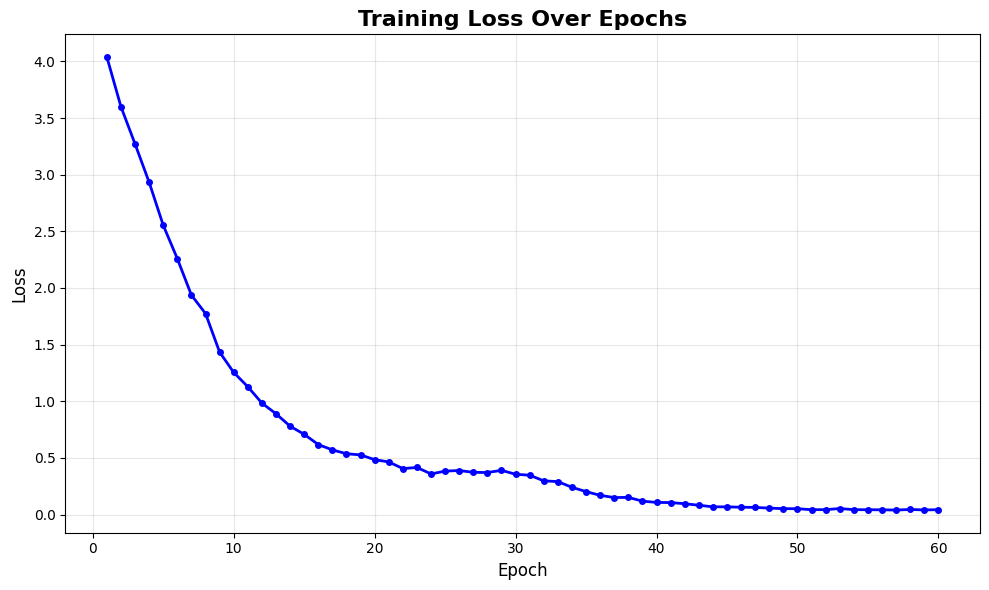

학습 완료!

학습 성공...


In [44]:
# Transformer 기반 LLM 학습/생성 Test Code
# 학습용 데이터 파일: The Old Man And The Sea_Korean.txt

import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from typing import Optional
from transformers import AutoTokenizer  # Transformers 라이브러리 직접 임포트
import warnings

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.family'] = 'DejaVu Sans'  # 한글 폰트 설정


# Transformers 경고 무시
warnings.filterwarnings(
    "ignore", message="Token indices sequence length is longer than")

print("="*60)
print("토크나이저 설정: KLUE/BERT")
print("="*60)
print()

print("="*60)
print("하드웨어 환경 확인")
print("="*60)
print(f"PyTorch 버전: {torch.__version__}")
print(f"CUDA 사용 가능: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"CUDA 버전: {torch.version.cuda}")
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(
        f"GPU 메모리: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
    device = 'cuda'
else:
    print("CPU 전용 모드")
    device = 'cpu'
print(f"사용 디바이스: {device}")
print()

# 학습용 데이터 로드
def load_text_data(filename='The Old Man And The Sea_Korean.txt'):
    try:
        with open(filename, 'r', encoding='utf-8') as f:
            sentences = [line.strip()
                         for line in f.readlines() if line.strip()]
        print(f"파일에서 {len(sentences)}개의 문장 로드")

        if len(sentences) == 0:
            print(f"'{filename}' 파일이 비어 있음")
            exit(1)

        return sentences
    except FileNotFoundError:
        print(f"'{filename}' 파일 없음")
        exit(1)

# 한국어 전용 토크나이저 (KLUE/BERT 기반)
class KoreanTokenizer:
    def __init__(self, texts):
        print("KLUE/BERT 토크나이저 초기화 중...")
        self.tokenizer = AutoTokenizer.from_pretrained("klue/bert-base")

        vocab_set = set()
        printed_count = 0
        total_texts = len(texts)

        for i, text in enumerate(texts):
            if i < 5 or i >= total_texts - 5:
                if printed_count == 5:
                    print("... (중간 과정 생략) ...")
                if i < 5 or i >= total_texts - 5:
                    print(f"토크나이징 진행: {i+1}/{total_texts}")
                    printed_count += 1

            truncated_text = text[:100] if len(text) > 100 else text
            tokens = self.tokenizer.tokenize(truncated_text)
            vocab_set.update(tokens)

        special_tokens = ['<pad>', '<sos>', '<eos>', '<unk>']
        bert_special = ['[PAD]', '[UNK]', '[CLS]', '[SEP]', '[MASK]']

        self.vocab = special_tokens + bert_special + sorted(list(vocab_set))
        self.vocab_size = len(self.vocab)
        self.token_to_idx = {token: i for i, token in enumerate(self.vocab)}
        self.idx_to_token = {i: token for i, token in enumerate(self.vocab)}

        print("="*60)
        print("토크나이저 정보")
        print("="*60)
        print(f"토크나이저 타입: KLUE/BERT WordPiece")
        print(f"어휘 크기: {self.vocab_size:,}")
        print(f"토큰 예시: {self.vocab[9:19]}")
        print(f"특수 토큰: {['<pad>', '<sos>', '<eos>', '<unk>']}")
        print()

    def encode(self, text):
        truncated_text = text[:100] if len(text) > 100 else text
        bert_tokens = self.tokenizer.tokenize(truncated_text)
        token_ids = [self.token_to_idx['<sos>']]
        for token in bert_tokens:
            token_ids.append(self.token_to_idx.get(
                token, self.token_to_idx['<unk>']))
        token_ids.append(self.token_to_idx['<eos>'])
        return token_ids

    def decode(self, token_ids):
        tokens = []
        for idx in token_ids:
            token = self.idx_to_token[idx]
            if token not in ['<pad>', '<sos>', '<eos>', '<unk>', '[PAD]', '[UNK]', '[CLS]', '[SEP]', '[MASK]']:
                tokens.append(token)

        return self.tokenizer.convert_tokens_to_string(tokens)

# 위치 인코딩
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int = 5000):
        super().__init__()

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()

        div_term = torch.exp(torch.arange(0, d_model, 2).float() *
                             -(math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

        print("="*60)
        print("위치 인코딩 정보")
        print("="*60)
        print(f"임베딩 차원: {d_model}")
        print(f"최대 길이: {max_len}")
        print(f"PE 값 범위: [{pe.min():.3f}, {pe.max():.3f}]")
        print("sin/cos 함수로 생성")
        print()

    def forward(self, x):
        seq_len = x.size(1)
        return x + self.pe[:, :seq_len]

# 멀티헤드 어텐션 메커니즘
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model: int, n_heads: int, dropout: float = 0.1):
        super().__init__()
        assert d_model % n_heads == 0

        self.d_model = d_model
        self.n_heads = n_heads
        self.d_k = d_model // n_heads

        self.w_q = nn.Linear(d_model, d_model)
        self.w_k = nn.Linear(d_model, d_model)
        self.w_v = nn.Linear(d_model, d_model)
        self.w_o = nn.Linear(d_model, d_model)

        self.dropout = nn.Dropout(dropout)
        self.scale = math.sqrt(self.d_k)

    def forward(self, x, mask: Optional[torch.Tensor] = None, verbose: bool = False):
        batch_size, seq_len = x.size(0), x.size(1)

        if verbose:
            print("\n" + "="*50)
            print("Attention Mechanism Analysis")
            print("="*50)
            print(f"Input shape: {x.shape}")
            print(f"Batch size: {batch_size}, Sequence length: {seq_len}")
            print(
                f"Number of heads: {self.n_heads}, Head dimension: {self.d_k}")

        Q = self.w_q(x)
        K = self.w_k(x)
        V = self.w_v(x)

        if verbose:
            print(f"Q, K, V shape: {Q.shape}")
            print(
                f"Q sample (first token, first 5 values): {Q[0, 0, :5].detach()}")

        Q = Q.view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)
        K = K.view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)
        V = V.view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)

        if verbose:
            print(f"Multi-head Q, K, V shape: {Q.shape}")
            print(f"First head Q sample: {Q[0, 0, 0, :5].detach()}")

        scores = torch.matmul(Q, K.transpose(-2, -1)) / self.scale

        if verbose:
            print(f"Attention scores shape: {scores.shape}")
            print(f"Scaling factor: {self.scale:.3f}")
            print(f"Attention scores sample (first head, 3x3):")
            print(f"{scores[0, 0, :3, :3].detach()}")

        if mask is not None:
            if verbose:
                print(f"Causal mask shape: {mask.shape}")
                print(f"Causal mask sample (3x3):")
                print(f"{mask[0, 0, :3, :3]}")

            scores = scores.masked_fill(mask == 0, -1e9)

            if verbose:
                print(f"Masked attention scores (3x3):")
                print(f"{scores[0, 0, :3, :3].detach()}")

        attn_weights = F.softmax(scores, dim=-1)
        attn_weights = self.dropout(attn_weights)

        if verbose:
            print(f"Attention weights shape: {attn_weights.shape}")
            print(f"Attention weights sample (first head, 3x3):")
            print(f"{attn_weights[0, 0, :3, :3].detach()}")
            print(
                f"Row sums (should be 1.0): {attn_weights[0, 0, :3].sum(dim=-1).detach()}")

        output = torch.matmul(attn_weights, V)

        if verbose:
            print(f"Weighted value output shape: {output.shape}")
            print(f"First head output sample: {output[0, 0, 0, :5].detach()}")

        output = output.transpose(1, 2).contiguous().view(
            batch_size, seq_len, self.d_model)
        output = self.w_o(output)

        if verbose:
            print(f"Final attention output shape: {output.shape}")
            print("="*50)

        return output

# 피드포워드 신경망
class FeedForward(nn.Module):
    def __init__(self, d_model: int, d_ff: int, dropout: float = 0.1):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)
        self.activation = nn.ReLU()

    def forward(self, x, verbose: bool = False):
        if verbose:
            print("\n" + "="*40)
            print("Feed Forward Network")
            print("="*40)
            print(f"Input shape: {x.shape}")

        x = self.linear1(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.linear2(x)

        if verbose:
            print(f"Output shape: {x.shape}")
            print("="*40)

        return x

# Decoder Block
class DecoderBlock(nn.Module):
    def __init__(self, d_model: int, n_heads: int, d_ff: int, dropout: float = 0.1):
        super().__init__()
        self.attention = MultiHeadAttention(d_model, n_heads, dropout)
        self.feed_forward = FeedForward(d_model, d_ff, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask: Optional[torch.Tensor] = None, verbose: bool = False):
        attn_output = self.attention(x, mask, verbose)
        x = self.norm1(x + self.dropout(attn_output))

        ff_output = self.feed_forward(x, verbose)
        x = self.norm2(x + self.dropout(ff_output))

        if verbose:
            print(f"Decoder block final output: {x.shape}")
            print("="*50)

        return x

# GPT Style Decoder-Only Transformer
class GPTModel(nn.Module):
    def __init__(self, vocab_size: int, d_model: int, n_heads: int,
                 n_layers: int, d_ff: int, max_seq_len: int, dropout: float = 0.1):
        super().__init__()

        self.vocab_size = vocab_size
        self.d_model = d_model
        self.max_seq_len = max_seq_len
        self.n_heads = n_heads
        self.n_layers = n_layers
        self.d_ff = d_ff

        self.token_embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(d_model, max_seq_len)

        self.decoder_blocks = nn.ModuleList([
            DecoderBlock(d_model, n_heads, d_ff, dropout)
            for _ in range(n_layers)
        ])

        self.norm = nn.LayerNorm(d_model)
        self.output_projection = nn.Linear(d_model, vocab_size)
        self.dropout = nn.Dropout(dropout)

        print("="*60)
        print("모델 구조")
        print("="*60)
        print(f"모델 타입: GPT (Decoder-Only Transformer)")
        print(f"어휘 크기: {vocab_size:,}")
        print(f"임베딩 차원: {d_model}")
        print(f"어텐션 헤드: {n_heads}")
        print(f"디코더 층: {n_layers}")
        print(f"FFN 차원: {d_ff}")
        print(f"최대 시퀀스 길이: {max_seq_len}")
        print(f"드롭아웃: {dropout}")

        total_params = sum(p.numel() for p in self.parameters())
        print(f"총 파라미터: {total_params:,}")
        print()

    # 인과 마스크 생성 (자기회귀 모델용)
    def create_causal_mask(self, seq_len: int, device: torch.device):
        mask = torch.tril(torch.ones(seq_len, seq_len, device=device))
        return mask.unsqueeze(0).unsqueeze(0)

    def forward(self, x, verbose: bool = False):
        batch_size, seq_len = x.size()

        if verbose:
            print("\n" + "="*60)
            print("Model Forward Pass Analysis")
            print("="*60)
            print(f"Input shape: {x.shape}")
            print(f"Input token IDs (first sample): {x[0].detach()}")
            print(f"Batch size: {batch_size}, Sequence length: {seq_len}")

        x = self.token_embedding(x)

        if verbose:
            print(f"\n[1. Token Embedding]")
            print(f"Embedding shape: {x.shape}")
            print(
                f"First token embedding (first 5 values): {x[0, 0, :5].detach()}")

        x = x * math.sqrt(self.d_model)

        if verbose:
            print(
                f"Scaling factor: √{self.d_model} = {math.sqrt(self.d_model):.3f}")
            print(f"Scaled embedding (first 5 values): {x[0, 0, :5].detach()}")

        x = self.pos_encoding(x)
        x = self.dropout(x)

        if verbose:
            print(f"\n[2. Positional Encoding]")
            print(f"After positional encoding shape: {x.shape}")
            print(
                f"After positional encoding (first 5 values): {x[0, 0, :5].detach()}")

        causal_mask = self.create_causal_mask(seq_len, x.device)

        if verbose:
            print(f"\n[3. Causal Mask]")
            print(f"Causal mask shape: {causal_mask.shape}")
            print(f"Causal mask sample (lower triangular matrix):")
            mask_sample = causal_mask[0, 0, :min(5, seq_len), :min(5, seq_len)]
            print(mask_sample)

        if verbose:
            print(f"\n[4. Decoder Blocks Processing]")
            print(
                f"Total {len(self.decoder_blocks)} decoder blocks to process")

        for i, block in enumerate(self.decoder_blocks):
            if verbose:
                print(f"\n--- Decoder Block {i+1} ---")
                x_before = x.clone().detach()

            x = block(x, causal_mask, verbose and i == 0)

            if verbose:
                residual_effect = (x.detach() - x_before).abs().mean()
                print(
                    f"Block {i+1} residual effect (change amount): {residual_effect:.4f}")

        x = self.norm(x)

        if verbose:
            print(f"\n[5. Final Output]")
            print(f"After layer norm (first 5 values): {x[0, 0, :5].detach()}")

        logits = self.output_projection(x)

        if verbose:
            print(f"Final logits shape: {logits.shape}")
            print(
                f"Last token logits range: [{logits[0, -1].min().item():.3f}, {logits[0, -1].max().item():.3f}]")
            print("="*60)

        return logits

# 배치 데이터 생성
def create_batches(tokenizer, texts, max_seq_len, batch_size):
    all_tokens = []

    print(f"배치 생성 중... (최대 시퀀스 길이: {max_seq_len})")

    total_texts = len(texts)
    printed_count = 0

    for i, text in enumerate(texts):
        if i < 5 or i >= total_texts - 5:
            if printed_count == 5:
                print("... (중간 과정 생략) ...")
            print(f"처리된 텍스트: {i+1}/{total_texts}, 생성된 시퀀스: {len(all_tokens)}")
            printed_count += 1

        tokens = tokenizer.encode(text)

        if len(tokens) > max_seq_len:
            for start in range(0, len(tokens), max_seq_len - 2):
                chunk = tokens[start:start + max_seq_len - 2]
                if len(chunk) >= 10:
                    chunk = [tokenizer.token_to_idx['<sos>']] + \
                        chunk[1:-1] + [tokenizer.token_to_idx['<eos>']]

                    while len(chunk) < max_seq_len:
                        chunk.append(tokenizer.token_to_idx['<pad>'])

                    all_tokens.append(chunk)
        else:
            while len(tokens) < max_seq_len:
                tokens.append(tokenizer.token_to_idx['<pad>'])
            all_tokens.append(tokens)

    if len(all_tokens) == 0:
        print("ERROR: 처리된 토큰 시퀀스가 없음!")
        return []

    print(f"총 {len(all_tokens)}개의 시퀀스가 생성...")

    data = torch.tensor(all_tokens, dtype=torch.long)

    batches = []
    for i in range(0, len(data), batch_size):
        batch = data[i:i+batch_size]
        batches.append(batch)

    print(f"총 {len(batches)}개의 배치 생성...")
    return batches

# 모델 학습
def train_model(model, batches, tokenizer, epochs, device, lr=3e-4):
    if len(batches) == 0:
        print("ERROR: 학습할 배치가 없음!!")
        print("- 텍스트 파일의 문장이 너무 적거나")
        print("- 배치 크기가 너무 크거나")
        print("- 시퀀스 길이가 너무 길 수 있습니다.")
        return []

    model.train()
    optimizer = torch.optim.AdamW(
        model.parameters(), lr=lr, weight_decay=0.01, betas=(0.9, 0.95))
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer, T_0=epochs//2)

    criterion = nn.CrossEntropyLoss(
        ignore_index=tokenizer.token_to_idx['<pad>'])

    print("="*60)
    print("모델 학습 시작")
    print("="*60)
    print(f"학습 배치 수: {len(batches)}")
    print(f"초기 학습률: {lr}")

    losses = []

    for epoch in range(epochs):
        total_loss = 0
        num_batches = 0

        for batch_idx, batch in enumerate(batches):
            batch = batch.to(device, non_blocking=True)

            inputs = batch[:, :-1]
            targets = batch[:, 1:]

            optimizer.zero_grad()

            logits = model(inputs, verbose=(epoch == 0 and batch_idx == 0))

            loss = criterion(
                logits.reshape(-1, logits.size(-1)), targets.reshape(-1))

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()
            scheduler.step()

            total_loss += loss.item()
            num_batches += 1

            if num_batches >= min(20, len(batches)):
                break

        if num_batches > 0:
            avg_loss = total_loss / num_batches
            losses.append(avg_loss)
            current_lr = optimizer.param_groups[0]['lr']
            print(
                f"에포크 {epoch+1:2d}/{epochs}, 손실: {avg_loss:.4f}, 학습률: {current_lr:.6f}")
        else:
            print(f"에포크 {epoch+1:2d}/{epochs}, 배치 없음 - 학습 중단!!")
            break

    return losses

# 모델 저장
def save_model(model, tokenizer, filepath):
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'vocab_size': tokenizer.vocab_size,
        'd_model': model.d_model,
        'n_heads': model.n_heads,
        'n_layers': model.n_layers,
        'd_ff': model.d_ff,
        'max_seq_len': model.max_seq_len,
        'vocab': tokenizer.vocab,
        'token_to_idx': tokenizer.token_to_idx,
        'idx_to_token': tokenizer.idx_to_token,
    }
    torch.save(checkpoint, filepath)
    print(f"모델이 '{filepath}'에 저장되었습니다.")

def plot_training_loss(losses):
    if not losses:
        print("손실 데이터가 없어 그래프를 그릴 수 없습니다.")
        return

    plt.figure(figsize=(10, 6))
    epochs = range(1, len(losses) + 1)

    # 손실 그래프
    plt.plot(epochs, losses, 'b-', linewidth=2, marker='o', markersize=4)
    plt.title('Training Loss Over Epochs', fontsize=16, fontweight='bold')
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# 학습 실행 함수
def run_training():
    # 하이퍼파라미터 설정

    MAX_SEQ_LEN = 256     # 시퀀스 길이
    BATCH_SIZE = 3       # 배치 크기
    D_MODEL = 256        # 모델 크기
    N_HEADS = 16          # 헤드 수
    N_LAYERS = 12         # 레이어 수
    D_FF = 256           # FFN 크기
    EPOCHS = 60           # 에포크

    print("="*60)
    print("모델 학습 모드")
    print("="*60)
    print(f"시퀀스 길이: {MAX_SEQ_LEN}")
    print(f"배치 크기: {BATCH_SIZE}")
    print(f"모델 크기: {D_MODEL}")
    print()

    # 데이터 로드 및 토크나이저 생성
    texts = load_text_data()
    # 단일 토크나이저를 직접 생성합니다.
    tokenizer = KoreanTokenizer(texts)

    # 모델 생성
    model = GPTModel(
        vocab_size=tokenizer.vocab_size,
        d_model=D_MODEL,
        n_heads=N_HEADS,
        n_layers=N_LAYERS,
        d_ff=D_FF,
        max_seq_len=MAX_SEQ_LEN
    ).to(device)

    # 배치 데이터 생성
    batches = create_batches(tokenizer, texts, MAX_SEQ_LEN, BATCH_SIZE)

    if len(batches) == 0:
        print("ERROR: 배치 생성에 실패!!")
        print("1. 텍스트 파일에 충분한 내용이 있는지?")
        print("2. 텍스트 파일 인코딩이 UTF-8인지?")
        return False

    print(f"총 배치 수: {len(batches)}")

    # 모델 학습
    losses = train_model(model, batches, tokenizer, EPOCHS, device)

    # 모델 저장
    if losses:
        save_model(model, tokenizer, 'gpt_model.pth')

        plot_training_loss(losses)

        print("학습 완료!")
        return True
    else:
        print("학습 실패 - 모델 저장 실패!!")
        return False


# 학습 실행
print("모델 학습")
print("="*60)

success = run_training()

if success:
    print("\n학습 성공...")
else:
    print("\n학습 실패!!")

In [45]:
# 텍스트 생성 부분 (모델 로드 및 생성)

# 로드된 토크나이저 클래스
class LoadedTokenizer:
    def __init__(self, vocab, token_to_idx, idx_to_token):
        self.vocab = vocab
        self.vocab_size = len(vocab)
        self.token_to_idx = token_to_idx
        self.idx_to_token = idx_to_token

        self.tokenizer = AutoTokenizer.from_pretrained("klue/bert-base")

    def encode(self, text):
        # KLUE/BERT 인코딩
        truncated_text = text[:100] if len(text) > 100 else text
        bert_tokens = self.tokenizer.tokenize(truncated_text)
        token_ids = [self.token_to_idx['<sos>']]
        for token in bert_tokens:
            token_ids.append(self.token_to_idx.get(
                token, self.token_to_idx['<unk>']))
        token_ids.append(self.token_to_idx['<eos>'])
        return token_ids

    def decode(self, token_ids):
        # KLUE/BERT 디코딩
        tokens = []
        for idx in token_ids:
            token = self.idx_to_token[idx]
            if token not in ['<pad>', '<sos>', '<eos>', '<unk>', '[PAD]', '[UNK]', '[CLS]', '[SEP]', '[MASK]']:
                tokens.append(token)

        return self.tokenizer.convert_tokens_to_string(tokens)

# 모델 로드
def load_model(filepath, device):
    try:
        checkpoint = torch.load(filepath, map_location=device)
    except FileNotFoundError:
        print(f"모델 파일 '{filepath}'을 찾기 실패!!")
        return None, None

    # 토크나이저 복원 (use_bert, tokenizer_type 없이)
    tokenizer = LoadedTokenizer(
        checkpoint['vocab'],
        checkpoint['token_to_idx'],
        checkpoint['idx_to_token']
    )

    # 모델 생성 및 가중치 로드
    model = GPTModel(
        vocab_size=checkpoint['vocab_size'],
        d_model=checkpoint['d_model'],
        n_heads=checkpoint['n_heads'],
        n_layers=checkpoint['n_layers'],
        d_ff=checkpoint['d_ff'],
        max_seq_len=checkpoint['max_seq_len']
    ).to(device)

    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    print("="*60)
    print("모델 로드 완료")
    print("="*60)
    print(f"모델 타입: Decoder-Only Transformer")
    print(f"어휘 크기: {checkpoint['vocab_size']:,}")
    print(f"임베딩 차원: {checkpoint['d_model']}")
    print(f"어텐션 헤드: {checkpoint['n_heads']}")
    print(f"디코더 층: {checkpoint['n_layers']}")
    print(f"최대 시퀀스 길이: {checkpoint['max_seq_len']}")
    # 토크나이저 정보 고정
    print(f"토크나이저: KLUE/BERT")
    print()

    return model, tokenizer

# 텍스트 생성 (Top 5 후보 표시)
def generate_text_with_candidates(model, tokenizer, prompt, max_length, device, temperature=1.0, verbose=False):
    model.eval()
    with torch.no_grad():
        tokens = tokenizer.encode(prompt)
        if verbose:
            print(f"Input text: '{prompt}' (Temperature: {temperature})")
            print(f"Tokenized result: {tokens}")
            if len(tokens) > 0:
                decoded_tokens = [
                    f"{token_id}:{tokenizer.idx_to_token[token_id]}" for token_id in tokens]
                print(f"Token details: {decoded_tokens}")

        generated_tokens = tokens.copy()
        all_candidates = []

        for i in range(max_length):
            if len(generated_tokens) >= model.max_seq_len:
                if verbose:
                    print(
                        f"Maximum sequence length ({model.max_seq_len}) reached!")
                break

            input_tokens = generated_tokens[-model.max_seq_len:]
            current_input = torch.tensor([input_tokens], device=device)
            logits = model(current_input, verbose=(verbose and i == 0))
            next_token_logits = logits[0, -1]

            if temperature == 0.0:
                next_token = torch.argmax(next_token_logits).item()
                probs = F.softmax(next_token_logits, dim=-1)
            else:
                scaled_logits = next_token_logits / temperature
                probs = F.softmax(scaled_logits, dim=-1)
                next_token = torch.multinomial(probs, 1).item()

            top_probs, top_indices = torch.topk(probs, 5)
            step_candidates = []
            for j, (prob, idx) in enumerate(zip(top_probs, top_indices)):
                token = tokenizer.idx_to_token[idx.item()]
                step_candidates.append({
                    'rank': j + 1, 'token': token, 'probability': prob.item(),
                    'selected': idx.item() == next_token
                })
            all_candidates.append(step_candidates)

            if verbose and i < 5:
                current_text = tokenizer.decode(generated_tokens)
                print(f"\n--- Generation Step {i+1} ---")
                print(f"Current text: '{current_text}'")
                print(f"Next token candidates:")

                selected_in_top5 = any(c['selected'] for c in step_candidates)
                for candidate in step_candidates:
                    selected_mark = " ★" if candidate['selected'] else ""
                    token_idx = tokenizer.token_to_idx.get(
                        candidate['token'], tokenizer.token_to_idx['<unk>'])
                    preview_text = tokenizer.decode(
                        generated_tokens + [token_idx])
                    print(
                        f"  {candidate['rank']}. '{candidate['token']}' → '{preview_text}' (prob: {candidate['probability']:.4f}){selected_mark}")
                if not selected_in_top5:
                    selected_token = tokenizer.idx_to_token[next_token]
                    print(
                        f"  Actually selected token '{selected_token}' not in top 5")

            eos_token_id = tokenizer.token_to_idx.get('<eos>', -1)
            if next_token == eos_token_id:
                if verbose:
                    print(f"Encountered <eos> token, stopping generation...")
                break
            generated_tokens.append(next_token)

        generated_text = tokenizer.decode(generated_tokens)
        return generated_text, all_candidates

# 텍스트 생성
def run_generation(input_text, max_length=20):
    model, tokenizer = load_model('gpt_model.pth', device)
    if model is None:
        return

    print(f"입력 텍스트: '{input_text}'")
    print(f"생성 길이: {max_length}\n")
    temperatures = [0.3, 0.7, 1.0, 1.3, 1.7]
    temp_descriptions = [
        "가장 확률 높은 토큰 선택", "안정적인 토큰 생성",
        "균형잡힌 토큰 생성", "창의적 (다양한 표현)", "매우 창의적 (실험적 생성)"
    ]
    for i, (temp, desc) in enumerate(zip(temperatures, temp_descriptions)):
        print(f"{'='*60}")
        print(f"생성 #{i+1} - Temperature {temp} ({desc})")
        print(f"{'='*60}")
        result, _ = generate_text_with_candidates(
            model, tokenizer, input_text, max_length, device,
            temperature=temp, verbose=(i == 0)
        )
        print(f"생성 결과: '{result}'\n")
    print("텍스트 생성 완료!")

# 다중 생성 함수 (시드 변경으로 다양한 결과)
def run_multiple_generation(input_text, max_length=20, num_samples=5):
    print("="*60)
    print("GPT 모델 다중 텍스트 생성")
    print("="*60)
    model, tokenizer = load_model('gpt_model.pth', device)
    if model is None:
        return

    print(f"입력 텍스트: '{input_text}'")
    print(f"생성 길이: {max_length}")
    print(f"생성 개수: {num_samples}\n")
    results = []
    for i in range(num_samples):
        torch.manual_seed(42 + i * 123)
        temp = 0.8 + (i * 0.2)
        print(f"{'='*50}")
        print(f"생성 #{i+1} (Temperature: {temp:.1f})")
        print(f"{'='*50}")
        result, _ = generate_text_with_candidates(
            model, tokenizer, input_text, max_length, device,
            temperature=temp, verbose=(i == 0)
        )
        results.append(result)
        print(f"결과 #{i+1}: '{result}'\n")
    print("="*60)
    print("생성 결과 요약")
    print("="*60)
    for i, result in enumerate(results, 1):
        print(f"{i}. '{result}'")
    print("\n다중 텍스트 생성 완료!")
    return results


# --- 메인 실행 ---
print("모델 텍스트 생성")
print("="*60)
print("1. 기본 5개 생성: run_generation('입력텍스트')")
print("2. 다중 생성 (시드 변경): run_multiple_generation('입력텍스트')")
print("="*60)

# 기본 실행 (5개 Temperature 설정으로 생성)
run_generation("고기가", max_length=20)


모델 텍스트 생성
1. 기본 5개 생성: run_generation('입력텍스트')
2. 다중 생성 (시드 변경): run_multiple_generation('입력텍스트')
위치 인코딩 정보
임베딩 차원: 256
최대 길이: 256
PE 값 범위: [-1.000, 1.000]
sin/cos 함수로 생성

모델 구조
모델 타입: GPT (Decoder-Only Transformer)
어휘 크기: 54
임베딩 차원: 256
어텐션 헤드: 16
디코더 층: 12
FFN 차원: 256
최대 시퀀스 길이: 256
드롭아웃: 0.1
총 파라미터: 4,777,526

모델 로드 완료
모델 타입: Decoder-Only Transformer
어휘 크기: 54
임베딩 차원: 256
어텐션 헤드: 16
디코더 층: 12
최대 시퀀스 길이: 256
토크나이저: KLUE/BERT

입력 텍스트: '고기가'
생성 길이: 20

생성 #1 - Temperature 0.3 (가장 확률 높은 토큰 선택)
Input text: '고기가' (Temperature: 0.3)
Tokenized result: [1, 33, 3, 2]
Token details: ['1:<sos>', '33:고기', '3:<unk>', '2:<eos>']

Model Forward Pass Analysis
Input shape: torch.Size([1, 4])
Input token IDs (first sample): tensor([ 1, 33,  3,  2])
Batch size: 1, Sequence length: 4

[1. Token Embedding]
Embedding shape: torch.Size([1, 4, 256])
First token embedding (first 5 values): tensor([ 0.5848, -1.6111,  0.5732,  0.0364, -1.0626])
Scaling factor: √256 = 16.000
Scaled embedding (first 5 values): t